# Roman-Coronagraph Reference/Science Target Pitch and Solar Observability

This notebook builds on the example notebook from https://github.com/roman-corgi/roman_pointing to allow the user to query any science target and determine which reference stars are available to observe in tandem at any given time of the year. You will need to install roman-pointing to your environment to utilize this notebook. You will also need astropy, astroquery, matplotlib, and numpy (which would be installed be default with roman-pointing) along with pandas

In [51]:
from roman_pointing.roman_pointing import calcRomanAngles, getL2Positions, getSunPositions
import astropy.units as u
from astropy.time import Time
from astroquery.simbad import Simbad
from astropy.coordinates import (
    SkyCoord,
    Distance,
    get_body_barycentric,
    BarycentricMeanEcliptic,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas
import time
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch,Rectangle
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS

## Helper functions to query Simbad for science target data and to load a pandas dataframe of the reference stars

This function will query Simbad for the necessary information (ra, dec, pmra, pmdec, parallax, and radial velocity) for the science target. Reference star information is loaded in separately from a supplied catalog.

In [52]:
def LoadExistingDatabase(filename='RefStar_S10_2025-05-20.csv'):
    #Input a database csv filename and load it with pandas
    loadedCSV = pandas.read_csv(filename)
    return loadedCSV

In [53]:
def queryTap_byname(name):
    #Perform a Simbad TAP query to obtain information about a target. 'name' must be a simbad-recognizable identifier
    example_base = """SELECT TOP 1 oid, main_id, ids, ra, dec, coo_err_maj, coo_err_min, coo_err_angle, coo_qual, coo_bibcode,
                        pmra, pmdec, pm_err_maj, pm_err_min, pm_err_angle, pm_qual, pm_bibcode, plx_value, plx_err, plx_qual, plx_bibcode,
                        rvz_radvel, rvz_err, rvz_bibcode,
                        otype, otypes, sp_type, sp_bibcode, 
                        U, B, V, G, R, I, J, H, K, u_, g_, r_, i_, z_
                        FROM basic JOIN alltypes ON basic.oid = alltypes.oidref JOIN allfluxes ON basic.oid = allfluxes.oidref
                        JOIN ident ON basic.oid = ident.oidref JOIN ids ON basic.oid = ids.oidref
                        WHERE id = '{insertname}'
                        AND ra IS NOT NULL
                        AND dec IS NOT NULL;"""
    example = example_base.format(insertname=name)

    queryresult = Simbad.query_tap(example)

    time.sleep(1) #Sleeps are used to make sure CDS doesn't blacklist your IP for being a robot

    return queryresult

## Master Function to Plot Reference Star Observability
To determine solar and pitch angles for all of the reference stars to compare to the science target, it's easier to pre-load reference star information from a file rather than submit a Simbad query for each reference star. This function allows you to input any Simbad-known science target, select either all valid or a subset of reference stars (indicated by ranks 'A', 'B', and 'C' with 'A' being most likely to be usable), a delta_pitch angle restriction, and options for saving figures and csvs. The generated plots are:

The upper left plot shows the solar angle as a function of days of the year from 20270101, with the thick dashed blue line representing the "Science" target. Disallowed regions (solar/planet keepout) are shaded black. The upper center plot calculates the pitch angle as a function of days of the year for both "science" target and reference stars in the reference frame that is consistent with OS11. The upper right plot calculates the difference in pitch angle between science and each reference star, with the absolute minimum (among any science-reference pair combination) is the thicker blue line. The lower left plot combines the information from the upper left plot and the upper center plot to determine the days of the year when a science target and a given reference star are both observable in general (solar angle restriction) and when the delta pitch is within the user set condition (default, 5 degrees). The lower center plot squashes the information in the lower left plot to find the absolute minimum delta pitch between science and any given reference star for any day (and would still be generally observable). Finally, the lower right plot shows the number of available reference stars for the "science" target on any given day.


In [56]:
def PitchfromRefCatalog_Mod(sciname,ranks=['A','B','C'],delpitch=5.0,save=False,savedir='.'):
    ###Query information about a science target from Simbad and determine which reference stars from a selected list of reference stars are observable with the science target considering the
    ###solar keepout and delta_pitch restriction
    ###Inputs:
    ###sciname: Simbad-known star identifier for the science target
    ###ranks: List of strings representing reference star ranks to include. Can only accept 'A','B','C', and 'F'
    ###delpitch: Delta pitch restriction in degrees
    ###save: If true, save the generated figure and valid delta pitch and dates for each reference star to a csv
    ###savedir: where to save the generated figure and csv
    RefStars = LoadExistingDatabase('RefStar_S10_2025-05-20.csv')

    RefStarsOriginal = RefStars.iloc[:40] #This is a hardcoded value to only load in the nominal 40 reference stars currently being considered
    for rank in np.arange(len(ranks)):
        #print(ranks[rank])
        #if ranks[rank] != 'A' or ranks[rank] != 'B' or ranks[rank] != 'C' or ranks[rank] != 'F':
        #    raise Exception("Ranks can only be 'A', 'B', 'C', or 'F'")
        RefStarsRank = RefStarsOriginal.iloc[np.where(RefStarsOriginal["st_psfgrade"]==ranks[rank])]
        if RefStarsRank.shape[0] == 0:
            raise Exception("No Rank "+ranks[rank]+" stars in loaded table")
        if rank == 0:
            RefStarsNominal = RefStarsRank
        elif rank > 0:
            RefStarsNominal = pandas.concat([RefStarsNominal,RefStarsRank])
    RefStarsNominal = RefStarsNominal.reset_index(drop=True)
    #Create a new dataframe that will track days of the year and delta pitch angle calculations
    print('Selected reference stars:')
    print(RefStarsNominal["main_id"].values)
    pitchDFcolumns = RefStarsNominal["main_id"].values
    pitchDFcolumns = np.insert(pitchDFcolumns,0,'Day')
    #stop()


    #Create a pandas dataframe where the columns are delta pitch calculations for each reference star. Each row is day of the year
    delta_pitchDF = pandas.DataFrame(columns=pitchDFcolumns)


    t_str = ["2027-01-01T00:00:00.0"]
    t0 = Time(t_str, format="isot", scale="utc")
    ts = t0 + np.arange(365)*u.d

    time2027 = range(len(ts))
    delta_pitchDF["Day"] = time2027

    #Determine science properties
    result = queryTap_byname(sciname)
    #Need to replace nan values with placeholder values that assume 0 pm, 0 rvz, very small parallax
    result_pandas = result.to_pandas()
    if np.isnan(result_pandas.loc[0,"plx_value"]) == True:
        result_pandas.loc[0,"plx_value"] = 0.0001
    if np.isnan(result_pandas.loc[0,"pmra"]) == True:
        result_pandas.loc[0,"pmra"] = 0.0
    if np.isnan(result_pandas.loc[0,"pmdec"]) == True:
        result_pandas.loc[0,"pmdec"] = 0.0
    if np.isnan(result_pandas.loc[0,"rvz_radvel"]) == True:
        result_pandas.loc[0,"rvz_radvel"] = 0.0

    target = SkyCoord(
                        result_pandas.loc[0,"ra"],
                        result_pandas.loc[0,"dec"],
                        unit=(u.deg, u.deg),
                        frame="icrs",
                        distance=Distance(parallax=result_pandas.loc[0,"plx_value"] * u.mas),
                        pm_ra_cosdec=result_pandas.loc[0,"pmra"] * u.mas/u.yr,
                        pm_dec=result_pandas.loc[0,"pmdec"] * u.mas/u.yr,
                        radial_velocity=result_pandas.loc[0,"rvz_radvel"] * u.km/u.s,
                        equinox="J2000",
                        obstime="J2000",
                        ).transform_to(BarycentricMeanEcliptic)

    sun_ang_targ, yaw_targ, pitch_targ, B_C_I_targ = calcRomanAngles(target, ts, getL2Positions(ts)) #Calculate angles for science target

    layout = '''
            ABC
            DEF
            '''

    fig1, axs = plt.subplot_mosaic(layout, layout='constrained',figsize=(14,6))

    fig1.suptitle(sciname,fontsize=18)

    axs['A'].set_xlabel(f"Time after {ts[0].value} (days)",fontsize=10)
    axs['A'].set_ylabel("Solar Angle (deg)",fontsize=14)
    axs['A'].set_xlim([np.min(time2027),np.max(time2027)])
    axs['A'].set_ylim([0,180])
    axs['B'].set_xlabel(f"Time after {ts[0].value} (days)",fontsize=10)
    axs['B'].set_ylabel("Pitch Angle (deg)",fontsize=14)
    axs['B'].set_xlim([np.min(time2027),np.max(time2027)])
    axs['C'].set_xlabel(f"Time after {ts[0].value} (days)",fontsize=10)
    axs['C'].set_ylabel(r"Absolute $\Delta$Pitch (deg)",fontsize=14)
    axs['C'].set_xlim([np.min(time2027),np.max(time2027)])
    axs['D'].set_xlabel(f"Time after {ts[0].value} (days)",fontsize=10)
    axs['D'].set_ylabel(r"Absolute $\Delta$Pitch (deg)",fontsize=14)
    axs['D'].set_xlim([np.min(time2027),np.max(time2027)])
    sun_angs = [] #all solar angles from all ref stars
    pitch_angs = [] #all pitch angles from all ref stars
    abs_pitch_angs = [] #all delta pitch angles for all ref stars+target


    obslengths = np.array([]) #number of days of observability for each reference star/target pair

    abs_pitch_actualobs = [] #delta pitch angles when both ref and target observable and also delta pitch < 5 for all ref/target pairs
    obsdates_actualobs = [] #days when the above is satisfied for all ref/target pairs

    lines4legend = []


    for i in np.arange(RefStarsNominal.shape[0]):
        #Create skycoord object
        #Use Gaia RA and if it doesn't exist use simbad RA
        if np.isnan(RefStarsNominal.loc[i,"ra2016"]) == False and np.isnan(RefStarsNominal.loc[i,"pmra2016"]) == False and np.isnan(RefStarsNominal.loc[i,"st_radv2016"]) == False and np.isnan(RefStarsNominal.loc[i,"sy_plx2016"]) == False:
            ra = RefStarsNominal.loc[i,"ra2016"]
            ra_unit = u.deg
            dec = RefStarsNominal.loc[i,"dec2016"]
            dec_unit = u.deg
            pmra = RefStarsNominal.loc[i,"pmra2016"]
            pmra_unit = u.mas/u.yr
            pmdec = RefStarsNominal.loc[i,"pmdec2016"]
            pmdec_unit = u.mas/u.yr
            plx = RefStarsNominal.loc[i,"sy_plx2016"]
            plx_unit = u.mas
            radv = RefStarsNominal.loc[i,"st_radv2016"]
            radv_unit = u.km/u.s
            obstime = "J2016"
        else:
            ra = RefStarsNominal.loc[i,"ra"]
            ra_unit = u.deg
            dec = RefStarsNominal.loc[i,"dec"]
            dec_unit = u.deg
            pmra = RefStarsNominal.loc[i,"sy_pmra"]
            pmra_unit = u.mas/u.yr
            pmdec = RefStarsNominal.loc[i,"sy_pmdec"]
            pmdec_unit = u.mas/u.yr
            plx = RefStarsNominal.loc[i,"sy_plx"]
            plx_unit = u.mas
            radv = RefStarsNominal.loc[i,"st_radv"]
            radv_unit = u.km/u.s
            obstime = "J2000"

        ref = SkyCoord(
                    ra,
                    dec,
                    unit=(ra_unit, dec_unit),
                    frame="icrs",
                    distance=Distance(parallax=plx * plx_unit),
                    pm_ra_cosdec=pmra * pmra_unit,
                    pm_dec=pmdec * pmdec_unit,
                    radial_velocity=radv * radv_unit,
                    equinox=obstime,
                    obstime=obstime,
                    ).transform_to(BarycentricMeanEcliptic)

        sun_ang_ref, yaw_ref, pitch_ref, B_C_I_targ = calcRomanAngles(ref, ts, getL2Positions(ts))
        fulldeltapitch = np.abs(pitch_targ - pitch_ref).to(u.deg)
        sun_angs.append(sun_ang_ref)
        pitch_angs.append(pitch_ref)
        abs_pitch_angs.append(fulldeltapitch)
        axs['A'].plot(range(len(ts)), sun_ang_ref.to(u.deg),label=RefStarsNominal.loc[i,"main_id"])
        axs['B'].plot(range(len(ts)), pitch_ref.to(u.deg),label=RefStarsNominal.loc[i,"main_id"])
        line2add, = axs['C'].plot(range(len(ts)),fulldeltapitch,label=RefStarsNominal.loc[i,"main_id"])
        lines4legend.append(line2add)

        actualobsdates = np.array([])
        obsdeltapitch = np.array([])
        for j in time2027:
            if sun_ang_targ.to(u.deg)[j] <=126*u.deg and sun_ang_targ.to(u.deg)[j] >= 54*u.deg and sun_ang_ref.to(u.deg)[j] <=126*u.deg and sun_ang_ref.to(u.deg)[j] >= 54*u.deg and fulldeltapitch[j] <= delpitch*u.deg:
                actualobsdates = np.append(actualobsdates,j)
                obsdeltapitch = np.append(obsdeltapitch,fulldeltapitch[j].value)
            else:
                actualobsdates = np.append(actualobsdates,np.nan)
                obsdeltapitch = np.append(obsdeltapitch,np.nan)
        obslengths = np.append(obslengths,len(actualobsdates[np.where(np.isnan(actualobsdates)==False)]))
        abs_pitch_actualobs.append(obsdeltapitch)
        obsdates_actualobs.append(actualobsdates)
        print(len(actualobsdates[np.where(np.isnan(actualobsdates)==False)]),"days of general and < "+str(delpitch)+" degree Delta pitch angle observability with "+RefStarsNominal.loc[i,"main_id"])
        RefStarsNominal.loc[i,"ObsDays"] = len(actualobsdates[np.where(np.isnan(actualobsdates)==False)])
        axs['D'].plot(actualobsdates, obsdeltapitch*u.deg,marker='o')
        delta_pitchDF[pitchDFcolumns[i+1]] = obsdeltapitch
    fullstackpitch = np.array(abs_pitch_angs)
    absminpitch = np.nanmin(fullstackpitch,axis=0)
    fullstackobs_pitch = np.array(abs_pitch_actualobs)
    fullstackobs_pitch_days = np.array(obsdates_actualobs)
    obs_absminpitch = np.nanmin(fullstackobs_pitch,axis=0)
    print(len(obs_absminpitch[np.where(np.isnan(obs_absminpitch)==False)]),"days of general and < "+str(delpitch)+" degree Delta pitch angle observability with any available ref")

    #Determine number of reference stars each day that satisfy <5 degree delta pitch and target/ref pair generally observable
    net_stars_obs = np.array([])
    for i in np.arange(len(time2027)):
        dayslice = fullstackobs_pitch[:,i]
        numstars = len(dayslice[np.where(np.isnan(dayslice)==False)])
        net_stars_obs = np.append(net_stars_obs,numstars)

    axs['A'].plot(range(len(ts)), sun_ang_targ.to(u.deg),'b',label="Sci:"+sciname,linewidth=5,linestyle='--')
    axs['B'].plot(range(len(ts)), pitch_targ.to(u.deg),'b',label="Sci:"+sciname,linewidth=5,linestyle='--')

    axs['A'].plot([0, len(ts)-1], [54] * 2, "k--")
    axs['A'].plot([0, len(ts)-1], [126] * 2, "k--")
    axs['A'].fill_between(
                        [0, len(ts)-1],
                        [54] * 2,
                        [0] * 2,
                        #hatch="/",
                        color="k",
                        #alpha=0.75,
                        edgecolor="k",
                        linewidth=0)
    axs['A'].fill_between(
                        [0, len(ts)-1],
                        [126] * 2,
                        [180] * 2,
                        #hatch="\\",
                        color="k",
                        #alpha=0.75,
                        edgecolor="k",
                        linewidth=0)

    

    absminline, = axs['C'].plot(time2027,absminpitch,linewidth=5,color='b',label='Abs. Min.')
    #Add a legend if you don't have too many reference stars
    
    axs['C'].legend(handles=[absminline],fontsize=10)
    if RefStarsNominal.shape[0] < 20:
        fig1.legend(handles=lines4legend,loc='outside center right',fontsize=10)


    axs['E'].plot(np.nanmin(np.array(obsdates_actualobs),axis=0),np.nanmin(np.array(abs_pitch_actualobs),axis=0),marker='o',color='b')
    axs['E'].set_xlabel(f"Time after {ts[0].value} (days)",fontsize=10)
    axs['E'].set_ylabel(r"Abs. Min. $\Delta$ Pitch (deg)",fontsize=14)
    axs['E'].set_xlim([np.min(time2027),np.max(time2027)])
    axs['F'].scatter(time2027,net_stars_obs,color='b')
    axs['F'].set_xlabel(f"Time after {ts[0].value} (days)",fontsize=10)
    axs['F'].set_ylabel("Number of Reference Stars",fontsize=14)
    axs['F'].set_xlim([np.min(time2027),np.max(time2027)])

    SortedRefs = RefStarsNominal.sort_values(by=['ObsDays'],ascending=False)
    print('Most Observable Reference Stars with Science Target '+sciname)
    print(SortedRefs[["main_id","ObsDays"]])

    #fig1.tight_layout()
    if save == True:
        sciname = sciname.replace("*","")
        ranklist = "".join(ranks)
        fig1.savefig(savedir+"/SciObs_"+sciname.replace(" ","")+"_Ranks"+ranklist+"_delPitch_"+str(delpitch).replace(".","_")+".jpg")
        delta_pitchDF.to_csv(savedir+"/SciObs_"+sciname.replace(" ","")+"_Ranks"+ranklist+"_delPitch_"+str(delpitch).replace(".","_")+".csv",index=False)


    plt.show()
    
    

Selected reference stars:
['* alf Lep' '* del Leo' '* bet UMa' '* eta CMa' '* alf Cep' '* gam TrA'
 '* del Cru' '* bet Car']
0 days of general and < 10.0 degree Delta pitch angle observability with * alf Lep
54 days of general and < 10.0 degree Delta pitch angle observability with * del Leo
131 days of general and < 10.0 degree Delta pitch angle observability with * bet UMa
27 days of general and < 10.0 degree Delta pitch angle observability with * eta CMa
35 days of general and < 10.0 degree Delta pitch angle observability with * alf Cep
30 days of general and < 10.0 degree Delta pitch angle observability with * gam TrA
0 days of general and < 10.0 degree Delta pitch angle observability with * del Cru
51 days of general and < 10.0 degree Delta pitch angle observability with * bet Car
171 days of general and < 10.0 degree Delta pitch angle observability with any available ref
Most Observable Reference Stars with Science Target 47 UMa
     main_id  ObsDays
2  * bet UMa    131.0
1  * del

/var/folders/_g/xxw7g6gs5yz0vfxg4s5nb12m0000gs/T/ipykernel_47453/3055524011.py:182: RuntimeWarning: All-NaN slice encountered
  obs_absminpitch = np.nanmin(fullstackobs_pitch,axis=0)
/var/folders/_g/xxw7g6gs5yz0vfxg4s5nb12m0000gs/T/ipykernel_47453/3055524011.py:226: RuntimeWarning: All-NaN slice encountered
  axs['E'].plot(np.nanmin(np.array(obsdates_actualobs),axis=0),np.nanmin(np.array(abs_pitch_actualobs),axis=0),marker='o',color='b')


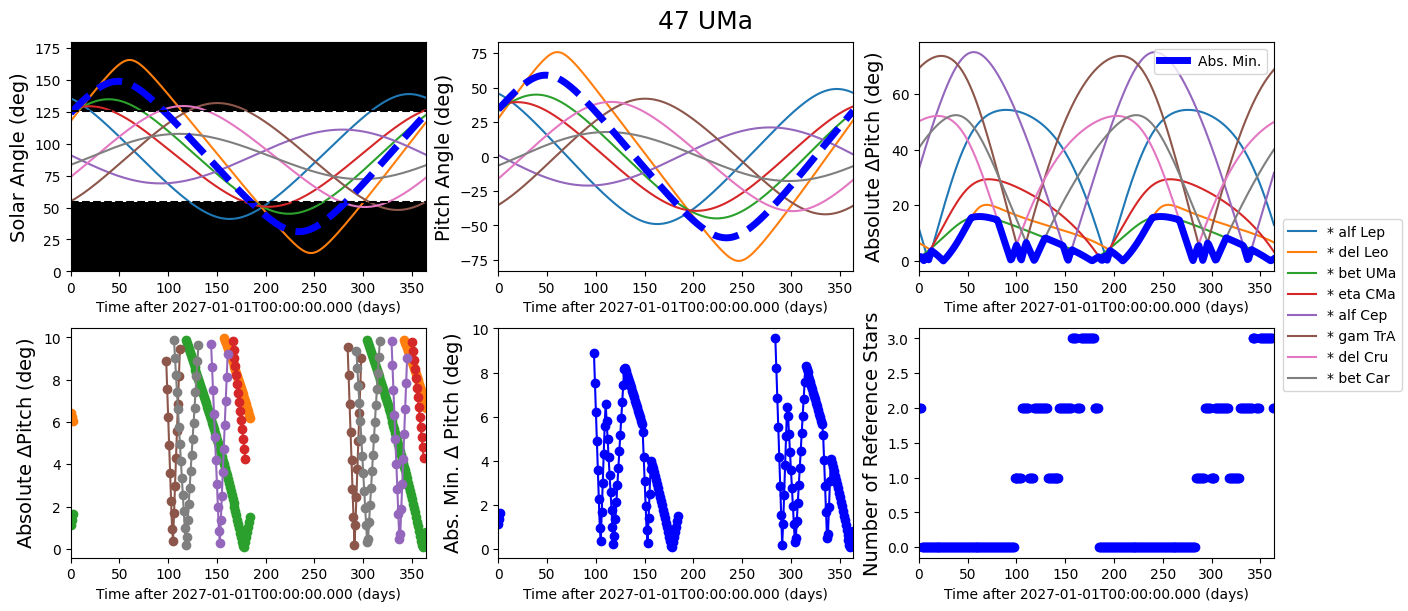

In [57]:
PitchfromRefCatalog_Mod('47 UMa',ranks = ['A'],delpitch=10.0)